In [62]:
import sys
import pandas as pd
import numpy as np
from ISLP import load_data
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

In [63]:
df = load_data('Wage')
print("Cols & data types:")
print(df.dtypes)

print("\nFirst 5 rows:")
display(df.head())

print(f"dataset shape: {df.shape}\n ")

Cols & data types:
year             int64
age              int64
maritl        category
race          category
education     category
region        category
jobclass      category
health        category
health_ins    category
logwage        float64
wage           float64
dtype: object

First 5 rows:


,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


dataset shape: (3000, 11)
 


## Part a
Split the data into training (70%) and testing (30%) data sets. Use seed 598 for reproducibility of the results.

In [64]:
#split features into categorical and numeric (for later preprocessing)
target = 'wage'
leakage = 'logwage'
feature_cols = [c for c in df.columns if c != target and c != leakage]

categorical_features = [c for c in feature_cols if df[c].dtype.name in ('object', 'category')]
numeric_features = [c for c in feature_cols if c not in categorical_features]

print("Categorical:", categorical_features)
print("Numeric:", numeric_features)

Categorical: ['maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins']
Numeric: ['year', 'age']


In [65]:
#Train/test split
from sklearn.model_selection import train_test_split

X = df[feature_cols].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=598
)

print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (2100, 9), Test size: (900, 9)


In [66]:
print("Shapes:")
print("X train size:", X_train.shape, " y train size:", y_train.shape)
print("X test size :", X_test.shape,  " y test size :", y_test.shape)

Shapes:
X train size: (2100, 9)  y train size: (2100,)
X test size : (900, 9)  y test size : (900,)


## Part b
Fit a tree model and visualize it. Interpret at least two splits.

In [67]:
#preprocessing pipeline
#diffeent preprocessing for categorical and numeric features
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preproc = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical_features),
        ("num", "passthrough", numeric_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

#model pipeline with decision tree regressor
tree = DecisionTreeRegressor(random_state=598)
pipe_tree = Pipeline([
    ("prep", preproc),
    ("model", tree),
])

#fit and eval model
pipe_tree.fit(X_train, y_train)
y_pred = pipe_tree.predict(X_test)
test_mse_unpruned = mean_squared_error(y_test, y_pred)
print(f"b) unpruned decision tree test MSE: {test_mse_unpruned:.2f}")

b) unpruned decision tree test MSE: 2589.73


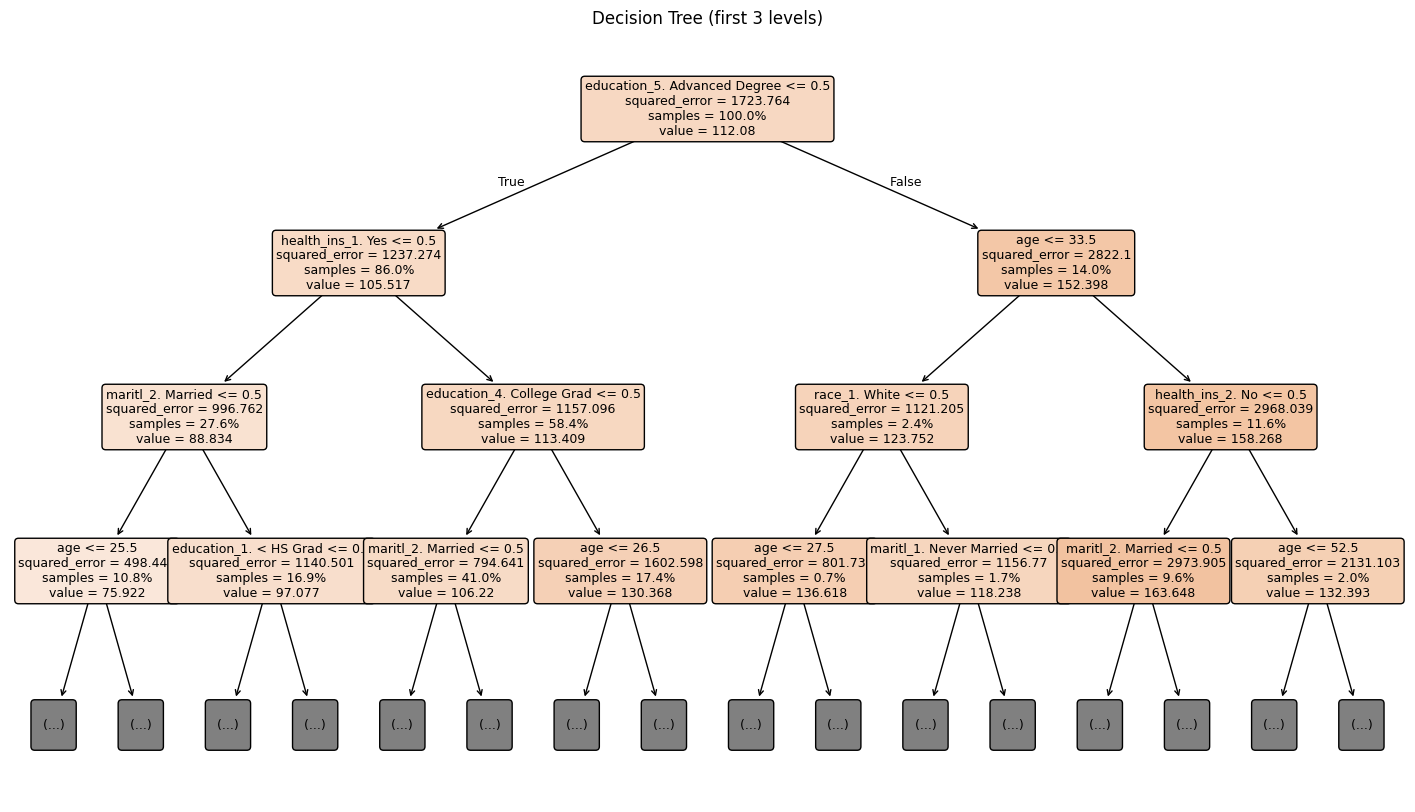

In [68]:
feature_names_out = pipe_tree.named_steps["prep"].get_feature_names_out()

plt.figure(figsize=(18, 10))
plot_tree(
    pipe_tree.named_steps["model"],
    feature_names=feature_names_out,
    filled=True,
    rounded=True,
    max_depth=3,
    impurity=True,
    proportion=True,
    fontsize=9
)
plt.title("Decision Tree (first 3 levels)")
plt.show()


### Split Interpretation

#### 1. Root split
We see that education level is the best separator between those with higher wages and lower wages. At the root, the decision tree decided to split based on education level. Since we have one hot vector encoded this feature (because it's categorical), we set 0 = non advanced degree and 1 = advanced degree. So the rule of advanced degree <= 0.5 is just True when the degree acheived is not advanced, and goes left, and is False when the degree is advanced and goes right. 

We can see from the samples variable that 86% of the dataset had no advanced degree, while 14% had an advanced degree. This means that education level is the strongest first separator, and that having an advanced degree is a good indicator of workers being in a higher wage group.

#### 2. First left split
We see that amongst those without advanced degrees, having health insurance has a strong correlation with higher wages. This is within the non advanced degree group. The next best indicator within this group that the decision tree model found was health insurance. This is the same case as education level with the one hot vector encoding, so 1 means has health insurance and 0 means does not have health insurance. So the rule of health insurance degree <= 0.5 is True when the worker does not have health insurance and goes left, and is False when the worker does have health insurance and goes right. 

We can see from the samples variable that 27.6% of the overall dataset had no health insurance (and no advanced education), while 58.4% of the overall dataset had health insurance (and no advanced eduacation). This means that amongst workers without advanced degrees, having health insurance has a strong correlation with higher wages, and those without insurance are in a lower wage branch.

## Part c

In [69]:
#build alpha grid from the pruning path
Xt_train = preproc.fit_transform(X_train)
tree0 = DecisionTreeRegressor(random_state=598)
tree0.fit(Xt_train, y_train)
path = tree0.cost_complexity_pruning_path(Xt_train, y_train)
alphas = np.unique(path.ccp_alphas)

#samole
idx = np.linspace(0, len(alphas)-1, num=min(25, len(alphas)), dtype=int)
alpha_grid = alphas[idx]

#cross validate ccp_alpha
pipe_for_cv = Pipeline([
    ("prep", clone(preproc)),
    ("model", DecisionTreeRegressor(random_state=598)),
])

#run gridsearch
cv = KFold(n_splits=5, shuffle=True, random_state=598)
grid = GridSearchCV(
    estimator=pipe_for_cv,
    param_grid={"model__ccp_alpha": alpha_grid},
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
)
grid.fit(X_train, y_train)

best_alpha = float(grid.best_params_["model__ccp_alpha"])
best_cv_mse = -grid.best_score_

#Fit unpruned vs pruned on train set, eval on test
pipe_unpruned = Pipeline([
    ("prep", clone(preproc)),
    ("model", DecisionTreeRegressor(random_state=598)),
])
pipe_unpruned.fit(X_train, y_train)
test_mse_unpruned = mean_squared_error(y_test, pipe_unpruned.predict(X_test))

pipe_pruned = Pipeline([
    ("prep", clone(preproc)),
    ("model", DecisionTreeRegressor(random_state=598, ccp_alpha=best_alpha)),
])
pipe_pruned.fit(X_train, y_train)
test_mse_pruned = mean_squared_error(y_test, pipe_pruned.predict(X_test))

In [70]:
print(f"Best ccp_alpha: {best_alpha:.6g}")
print(f"Cross Validation MSE at best alpha: {best_cv_mse:.2f}")
print(f"\nTest MSE for unpruned: ${test_mse_unpruned:.2f}")
print(f"Test MSE for pruned: ${test_mse_pruned:.2f}")
print(f"\nTest RMSE for unpruned: ${np.sqrt(test_mse_unpruned):.2f}")
print(f"Test RMSE for pruned: ${np.sqrt(test_mse_pruned):.2f}")

impr = 100 * (test_mse_unpruned - test_mse_pruned) / test_mse_unpruned
print(f"\nImprovement from pruning: {impr:.2f}%")

Best ccp_alpha: 264.615
Cross Validation MSE at best alpha: 1642.72

Test MSE for unpruned: $2589.73
Test MSE for pruned: $1780.67

Test RMSE for unpruned: $50.89
Test RMSE for pruned: $42.20

Improvement from pruning: 31.24%


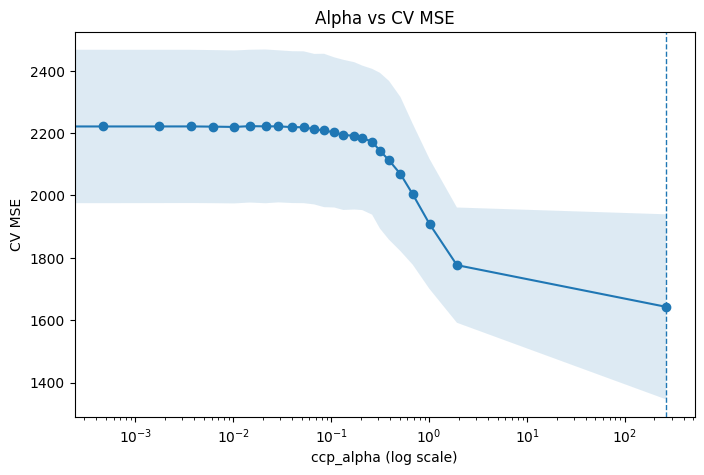

In [71]:
#alpha vs CV MSE
means = -grid.cv_results_["mean_test_score"]
stds  = grid.cv_results_["std_test_score"]
alph  = grid.cv_results_["param_model__ccp_alpha"].data.astype(float)

plt.figure(figsize=(8,5))
plt.semilogx(alph, means, marker="o")
plt.fill_between(alph, means - stds, means + stds, alpha=0.15)
plt.axvline(best_alpha, ls="--", lw=1)
plt.xlabel("ccp_alpha (log scale)")
plt.ylabel("CV MSE")
plt.title("Alpha vs CV MSE")
plt.show()


#### Conclusion on pruned vs. unpruned

Pruning substantially improved the model and generalization. On the test set, MSE dropped from 2589.73 to 1780.67, which is a 31.24% reduction. The RMSE change was from $50.89 to $42.20, which is about an $8.69 difference. So from this, we can determine that the pruned tree’s wage error is around $8-9 lower than the unpruned tree’s wage error.

The ccp_alpha vs. CV MSE graph clearly shows how pruning is better, because as pruning strength increases, the CV MSE falls, hitting its lowest at ccp_alpha = 264.615. This indicates the unpruned tree was overfitting, and simplifying the tree reduces error on unseen data without introducing too much bias.

## Part d
Fit a random forest model to the training data.
Choose two different values for mtry (in R) or max features (in Python). If you use R,
make sure that you include the variable importance (i.e. importance=TRUE in R) when
fitting the model. In Python, this is automatically included when you use
RandomForestRegressor. Comment on the results you obtain.

In [72]:
#helper to sum importances back to og features
def aggregated_feature_importances(pipeline, categorical_features, numeric_features):
    pre = pipeline.named_steps["prep"]
    model  = pipeline.named_steps["model"]
    importances = model.feature_importances_.ravel()

    ohe = pre.named_transformers_["cat"]
    category_lens = [len(cats) for cats in ohe.categories_]

    agg = {}
    idx = 0
    #sum importances
    for feature, k in zip(categorical_features, category_lens):
        agg[feature] = float(importances[idx:idx+k].sum())
        idx += k
    for feature in numeric_features:
        agg[feature] = float(importances[idx])
        idx += 1

    return sorted(agg.items(), key=lambda x: x[1], reverse=True)

In [73]:
#rf sqrt model
rf_sqrt = Pipeline([
    ("prep", clone(preproc)),
    ("model", RandomForestRegressor(
        n_estimators=500, max_features="sqrt", random_state=598, n_jobs=-1
    )),
])

#rf log2 model
rf_log2 = Pipeline([
    ("prep", clone(preproc)),
    ("model", RandomForestRegressor(
        n_estimators=500, max_features="log2", random_state=598, n_jobs=-1
    )),
])

#fit and pred
rf_sqrt.fit(X_train, y_train)
rf_log2.fit(X_train, y_train)

pred_sqrt = rf_sqrt.predict(X_test)
pred_log2 = rf_log2.predict(X_test)

mse_sqrt = mean_squared_error(y_test, pred_sqrt); rmse_sqrt = mse_sqrt**0.5
mse_log2 = mean_squared_error(y_test, pred_log2); rmse_log2 = mse_log2**0.5

In [74]:
print(f"SQRT Test MSE: {mse_sqrt:.2f} | RMSE: {rmse_sqrt:.2f}")
print(f"LOG2 Test MSE: {mse_log2:.2f} | RMSE: {rmse_log2:.2f}")

#pick the better rf
best_pipe = rf_sqrt if mse_sqrt <= mse_log2 else rf_log2
best_tag  = "sqrt" if best_pipe is rf_sqrt else "log2"
best_mse, best_rmse = (mse_sqrt, rmse_sqrt) if best_pipe is rf_sqrt else (mse_log2, rmse_log2)
print(f"\nBest RF setting: max_features='{best_tag}' "
      f"(Test MSE: {best_mse:.2f} | RMSE: {best_rmse:.2f})")

SQRT Test MSE: 1364.14 | RMSE: 36.93
LOG2 Test MSE: 1364.14 | RMSE: 36.93

Best RF setting: max_features='sqrt' (Test MSE: 1364.14 | RMSE: 36.93)


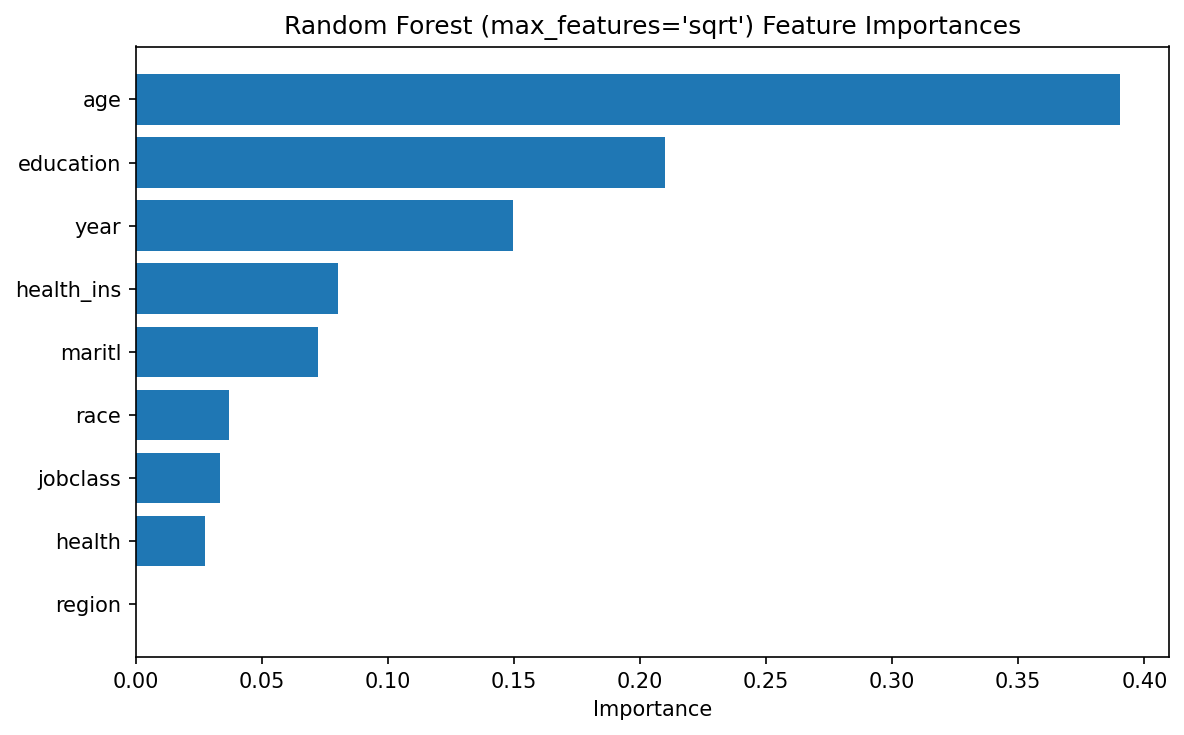


Top features:
age: 0.3903
education: 0.2098
year: 0.1495
health_ins: 0.0801
maritl: 0.0724
race: 0.0370
jobclass: 0.0335
health: 0.0273
region: 0.0000


In [75]:
#plot
sum_importances = aggregated_feature_importances(best_pipe, categorical_features, numeric_features)

names = [k for k, v in sum_importances][::-1]
vals  = [v for k, v in sum_importances][::-1]

plt.figure(figsize=(8, 5), dpi=150)
plt.barh(names, vals)
plt.xlabel("Importance") #miportance is just a sum of the one hot encoded vectors
plt.title(f"Random Forest (max_features='{best_tag}') Feature Importances")
plt.tight_layout()
plt.show()

# (Optional) print the full ranked list
print("\nTop features:")
for k, v in sum_importances[:20]:
    print(f"{k}: {v:.4f}")


#### Comments on the results

We used two max_features, sqrt and log2, and found that both gave us the same MSE of 1364.14. This likely happened because we had the same number of features per split after the one hot encoding. The pruned tree gave us an MSE of 1780.67, meaning the random forest model was a 23.4% drop in MSE, so the random forest is much better at generaliing than a single pruned tree.

Our final findings from the random forest was that age is the most dominant factor in determining wage, followed by education and year. Health insurance and marital status contribute moderately, while race, job class, and health have even lower contributions. Region has negligible impact on wages.

## Part e
Based on the random forest model in (d), which seem to be the most important predictors?

Based on the random forest model, the most important predictor was age, followed by education and year. The next tier was health insurance and marital status, and the third tier was race, job class, and health. The fourth tier had negligible impact, which was region.

We can see that this makes sense not just from a data standpoint, but from a practical standpoint as well. The older someone gets, the higher their wages get typically. Higher education typically also correlates with higher skill, and therefore higher wage, jobs, and year reflects economic factor on wage. Health insurance is typically associated with higher paying jobs, and being married often requires higher income.

## Part f
Report the testing MSE for the random forest model and compare with the (pruned)
regression tree fitted in (c).

The random forest model gave us a testing MSE of 1364.14. The single pruned tree gave us an MSE of 1780.67, meaning the random forest model was a 23.4% drop in MSE, so the random forest is much better at generaliing than a single pruned tree. If we look at the RMSEs, we can see that the RMSE of the random forest model is $36.93, whereas the RMSE of the pruned tree is $42.20, giving us about a $5 difference of prediction error. 

This happens because A single decision tree is a high-variance estimator, where small changes in the training data yield very different splits. Pruning controls variance but also increases bias. Random Forests decreases variance more effectively by training many trees by random feature subsampling at each split, which decorrelates the trees. It then averages these diverse trees, which preserves the trees ability to model nonlinearity and interactions while also signficantly reducing variance. That's why our MSE is lower on the random forest, because it generalizes better than a single pruned tree, which is much more prone to variance.

## Part g
Choose at least two learning rates (i.e. shrinkage option). If you use R, make sure you
choose distribution="gaussian" in the gbm package.
Plot the test MSE versus the number of trees, and interpret the two most influential
variables.

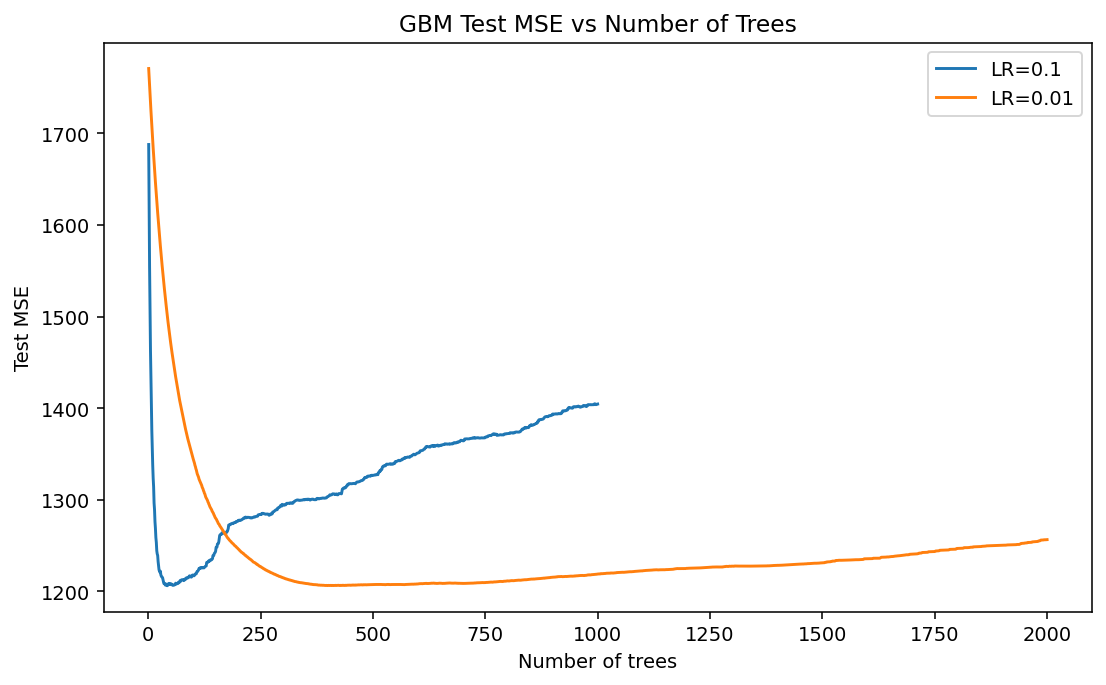

In [76]:
pre = clone(preproc)

#2 gbms
settings = [
    {"lr": 0.1,  "n": 1000},
    {"lr": 0.01, "n": 2000},
]

results = []
plt.figure(figsize=(8,5), dpi=140)

for cfg in settings:
    lr, n = cfg["lr"], cfg["n"]
    
    pipe_gbm = Pipeline([
        ("prep", clone(pre)),
        ("model", GradientBoostingRegressor(
            learning_rate=lr,
            n_estimators=n,
            max_depth=3,
            random_state=598
        )),
    ])

    #fit pipeline
    pipe_gbm.fit(X_train, y_train)

    #transform X_test
    pre_fitted = pipe_gbm.named_steps["prep"]
    Xt_test = pre_fitted.transform(X_test)
    model   = pipe_gbm.named_steps["model"]

    #test MSE vs num trees
    mses = []
    for y_pred in model.staged_predict(Xt_test):
        mses.append(mean_squared_error(y_test, y_pred))
    mses = np.array(mses)

    best_idx = int(np.argmin(mses))
    best_mse = float(mses[best_idx])
    best_rmse = best_mse**0.5
    results.append((lr, n, best_idx+1, best_mse, best_rmse, pipe_gbm))

    #plot
    plt.plot(np.arange(1, len(mses)+1), mses, label=f"LR={lr}")
plt.xlabel("Number of trees")
plt.ylabel("Test MSE")
plt.title("GBM Test MSE vs Number of Trees")
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
#best points and top feature oer GBM
for (lr, n, best_trees, best_mse, best_rmse, pipe_gbm) in results:
    print(f"GBM (learning_rate={lr}, n_estimators={n}) "
          f"best test MSE: {best_mse:.2f} | RMSE: {best_rmse:.2f} "
          f"at {best_trees} trees")

    agg_imps = aggregated_feature_importances(pipe_gbm, categorical_features, numeric_features)
    print("Top 5 features:")
    for name, imp in agg_imps[:5]:
        print(f"  {name}: {imp:.4f}")
    print()


GBM (learning_rate=0.1, n_estimators=1000) best test MSE: 1205.85 | RMSE: 34.73 at 42 trees
Top 5 features:
  education: 0.4334
  age: 0.2036
  health_ins: 0.1238
  maritl: 0.0955
  year: 0.0667

GBM (learning_rate=0.01, n_estimators=2000) best test MSE: 1206.05 | RMSE: 34.73 at 412 trees
Top 5 features:
  education: 0.4780
  age: 0.1690
  health_ins: 0.1491
  maritl: 0.1057
  year: 0.0438



#### Most influential variables

The most influential variables were, respectively, education and age.

Education was the most important feature in both GBMs, having between 0.43–0.48 importance, and age was the second most important in both GBMs, having ~0.17–0.20 importance.. The GBM model repeatedly splits on indicators in the trees, so since education and age have the most importance, it means education level and age create large changes in predicted wage. Since they the best predictors for both learning rates, we can determine that the results are stable and not a result of a given configuration.

## Part h
Compare the performance (i.e. MSE) of GBM on the testing data to the random forest
and (pruned) regression tree. Comment on the results.

For the GBM model, a learning rate of 0.1 saw its best testing MSE of 1205.85 (RMSE of 34.73) at 42 trees, and a learning rate of 0.01 saw its best testing MSE of 1206.05 (RMSE of 34.73) at 412 trees. The random forest saw an MSE of 1364.14 (RMSE of 36.93) and the pruned tree saw an MSE of 1780.67 (RMSE of 42.20).

The GBM is best, showing MSE improvements over the pruned tree by 32.28% (RMSE down from $42.20 to $34.73, which is about 17% improvement) and MSE improvements over the Random Forest by 11.60% (RMSE $36.93 to $34.73, which is about 5% improvement). The random forest and GBMs are close in MSE, but the GBM wins out. This makes sense, as random forest and GBM are designed to reduce variance while preserving nonlinearity and interactions, which a single tree can’t match.